# Exploratory Data Analysis of Crime in Chicago from 2012-2016

This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department’s CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified. Should you have questions about this dataset, you may contact the Research & Development Division of the Chicago Police Department at 312.745.6071 or RDAnalysis@chicagopolice.org.

The City of Chicago provides data on all reported incidents of crime in the city of Chicago from
2001 to present (minus seven days). At the time of download that included 6.03 million lines of
data, or approximately 400,000 crimes per year, or almost 8,000 crimes per week.

##### Importing Packages 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import folium
plt.style.use('seaborn')
import seaborn as sns
import geopy.distance
import math
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
import scikitplot as skplt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Import Crime Data from 2001 to 2018 
crimes = pd.read_csv("D:\\Data Science\\Clarity Insigts\\Crimes_-_2001_to_present.csv")

In [4]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6741475 entries, 0 to 6741474
Data columns (total 22 columns):
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Location                object
dtypes: bool(2), float64(7), int64(3), object(10)
memory usage: 1.0+ GB


In [5]:
# Drop Columns 
crimes.drop(['Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code'], inplace=True, axis=1)

In [6]:
socio = pd.read_csv("D:\\Data Science\\Clarity Insigts\\Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv")
population = pd.read_csv("D:\\Data Science\\Clarity Insigts\\Census_2010_and_2000_CA_Populations.csv" , dtype={'2010':int})
Police_Station = pd.read_csv("D:\\Data Science\\Clarity Insigts\\police-stations.csv" )
Zip = pd.read_csv("D:\\Data Science\\Clarity Insigts\\zip.csv" )
Police_Station.columns = [str(col) + '_Police' for col in Police_Station.columns]

In [7]:
crimes.Date = pd.to_datetime(crimes.Date, format='%m/%d/%Y %I:%M:%S %p')
crimes['Year'] = crimes['Date'].map(lambda x: x.year)

In [8]:
crimes = crimes[crimes['Year'] < 2017]

In [9]:
# Exploring Dataset 
crimes.head(3)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,Location,Year
0,10000092,2015-03-18 19:44:00,047XX W OHIO ST,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,41.891399,-87.744385,"(41.891398861, -87.744384567)",2015
1,10000094,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,41.773372,-87.665319,"(41.773371528, -87.665319468)",2015
2,10000095,2015-03-18 22:45:00,044XX S LAKE PARK AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,2.0,4.0,39.0,41.813861,-87.596643,"(41.81386068, -87.596642837)",2015


##### Duplicacy ??

In [10]:
print('Dataset Shape before drop_duplicate : ', crimes.shape)
crimes.drop_duplicates(subset=['ID'], inplace=True)
print('Dataset Shape after drop_duplicate: ', crimes.shape)

Dataset Shape before drop_duplicate :  (6249212, 16)
Dataset Shape after drop_duplicate:  (6249212, 16)


In [11]:
# convert dates to pandas datetime format
crimes.Date = pd.to_datetime(crimes.Date, format='%m/%d/%Y %I:%M:%S %p')
# setting the index to be the date will help us a lot later on
crimes.index = pd.DatetimeIndex(crimes.Date)

In [12]:
# of records X # of features
crimes.shape

(6249212, 16)

In [13]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6249212 entries, 2015-03-18 19:44:00 to 2008-06-01 12:00:00
Data columns (total 16 columns):
ID                      int64
Date                    datetime64[ns]
Block                   object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
Latitude                float64
Longitude               float64
Location                object
Year                    int64
dtypes: bool(2), datetime64[ns](1), float64(5), int64(3), object(5)
memory usage: 727.1+ MB


## Exploration 

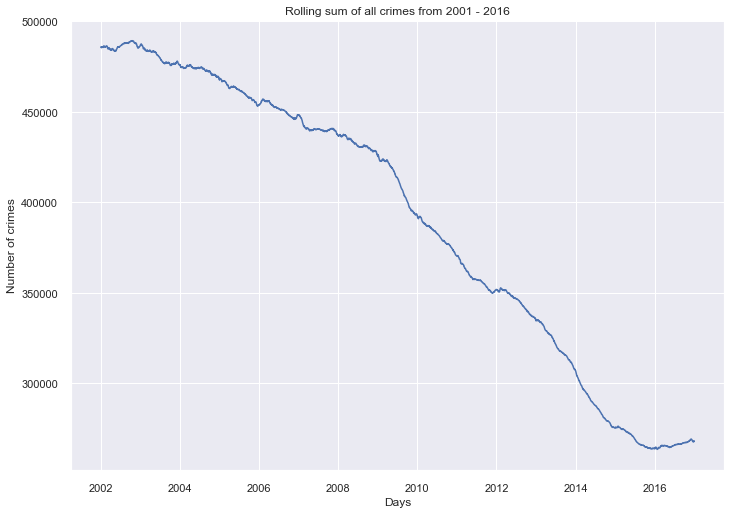

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.figure(figsize=(11.7,8.27))
crimes.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2001 - 2016')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

### Crime by Month 

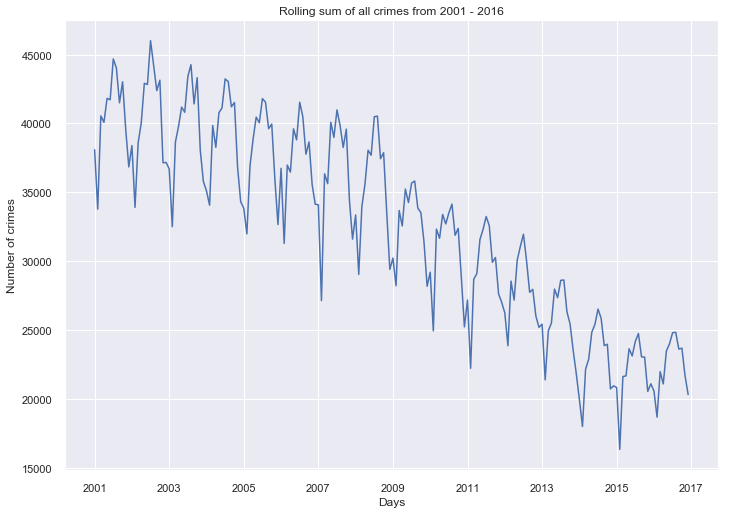

In [15]:
crimes.resample('M').size().plot(legend=False)
plt.title('Rolling sum of all crimes from 2001 - 2016')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

### Crime by Days of Week 

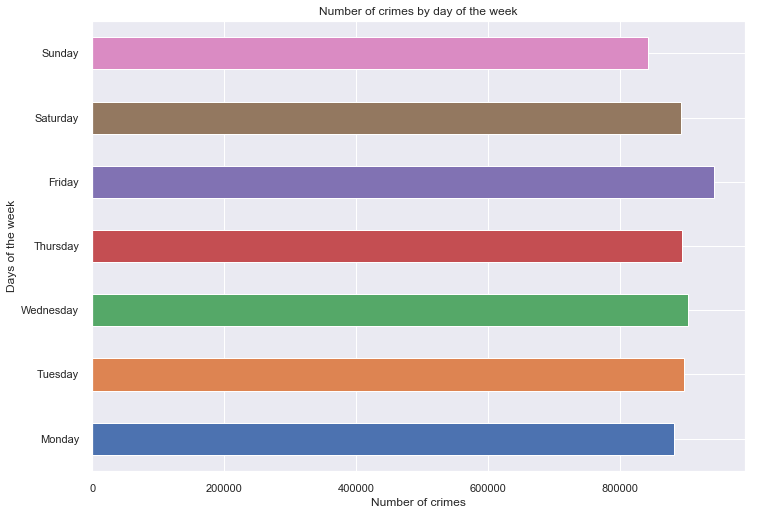

In [16]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes.groupby([crimes.index.dayofweek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

### Crime by Month 

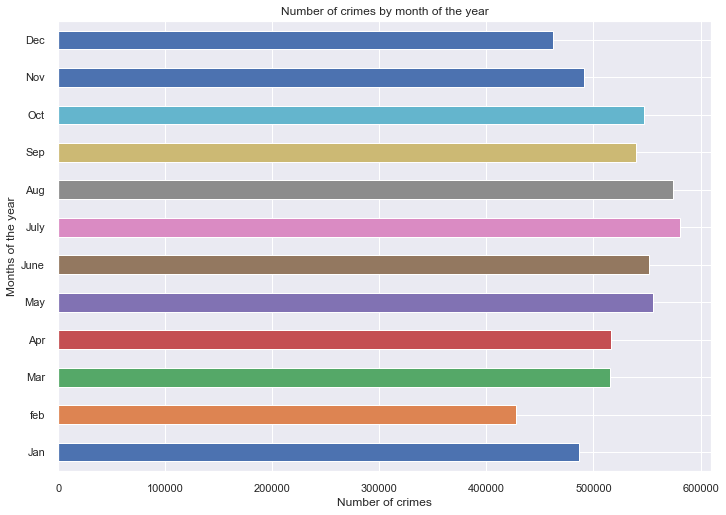

In [17]:
days = ['Jan','feb','Mar',  'Apr', 'May', 'June', 'July','Aug', 'Sep', 'Oct', 'Nov' ,'Dec']
crimes.groupby([crimes.index.month]).size().plot(kind='barh')
plt.ylabel('Months of the year')
plt.yticks(np.arange(12), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by month of the year')
plt.show()

As the Analysis Shows there is significant drop in crimes in the months of Winter  - Nov , Dec , Jan and Feb 


In [18]:
Analysis_1   = crimes.groupby([crimes.index.month]).size().reset_index()
x  = sum(Analysis_1[0][Analysis_1['Date'].isin([1,2,11,12])])/4
y  = sum(Analysis_1[0][Analysis_1['Date'].isin([3,4,5,6,7,8,9,10])])/8
change_percent = ((x-y)/y)*100
print("Crime percentage overall in Winters Drop by" ,round(change_percent,2) , "Percent")

Crime percentage overall in Winters Drop by -14.8 Percent


### Data Cleanup 

In [19]:
crimes['Primary Type'].value_counts()

THEFT                                1297803
BATTERY                              1139375
CRIMINAL DAMAGE                       718135
NARCOTICS                             688154
OTHER OFFENSE                         386545
ASSAULT                               381362
BURGLARY                              364842
MOTOR VEHICLE THEFT                   294241
ROBBERY                               235380
DECEPTIVE PRACTICE                    228056
CRIMINAL TRESPASS                     180520
PROSTITUTION                           66963
WEAPONS VIOLATION                      61242
PUBLIC PEACE VIOLATION                 45112
OFFENSE INVOLVING CHILDREN             41122
CRIM SEXUAL ASSAULT                    24105
SEX OFFENSE                            23131
GAMBLING                               14035
LIQUOR LAW VIOLATION                   13624
INTERFERENCE WITH PUBLIC OFFICER       12906
ARSON                                  10389
HOMICIDE                                8249
KIDNAPPING

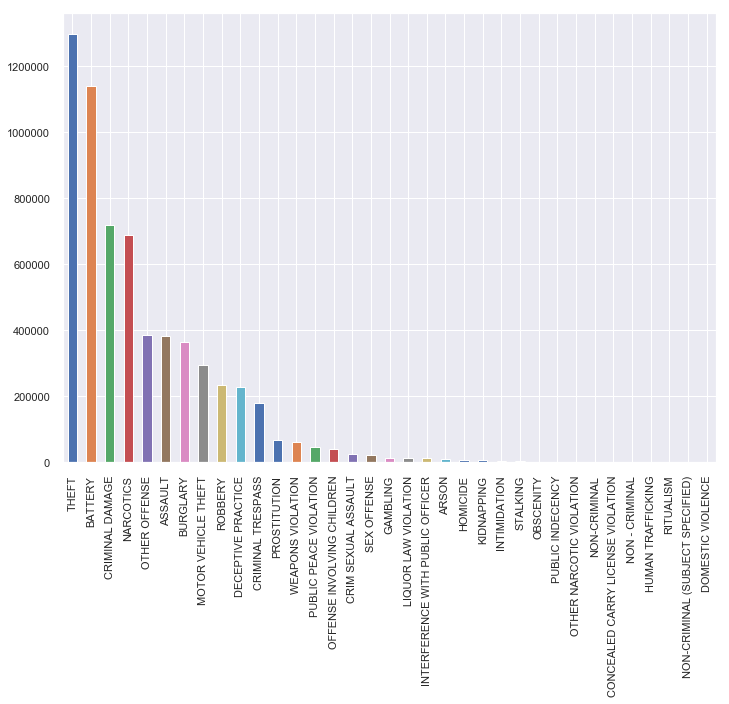

In [20]:
crimes['Primary Type'].value_counts().plot(kind = 'bar')

Although crime is decreasing overall, let's see if each type of crime decreases the same. News reports are focusing on very high rates of homicide and gun violence and that appears to be true. In order to compare different values we index each type against its average, so a score of 100 represents an average incidence of crime.

In [21]:
def hr_func(ts):
    return ts.hour

def month_func(ts):
    return ts.month

crimes['crime_hour'] = crimes['Date'].apply(hr_func)
crimes['Month'] = crimes['Date'].apply(month_func)
crimes['Day'] = crimes['Date'].map(lambda x: x.day)
crimes['DoW'] = crimes['Date'].map(lambda x: x.weekday())
crimes['Datestr'] = crimes['Date'].map(lambda x: x.date())
crimes['Counter'] = 1
crimes['Datestr'] = crimes['Datestr'].astype('datetime64')

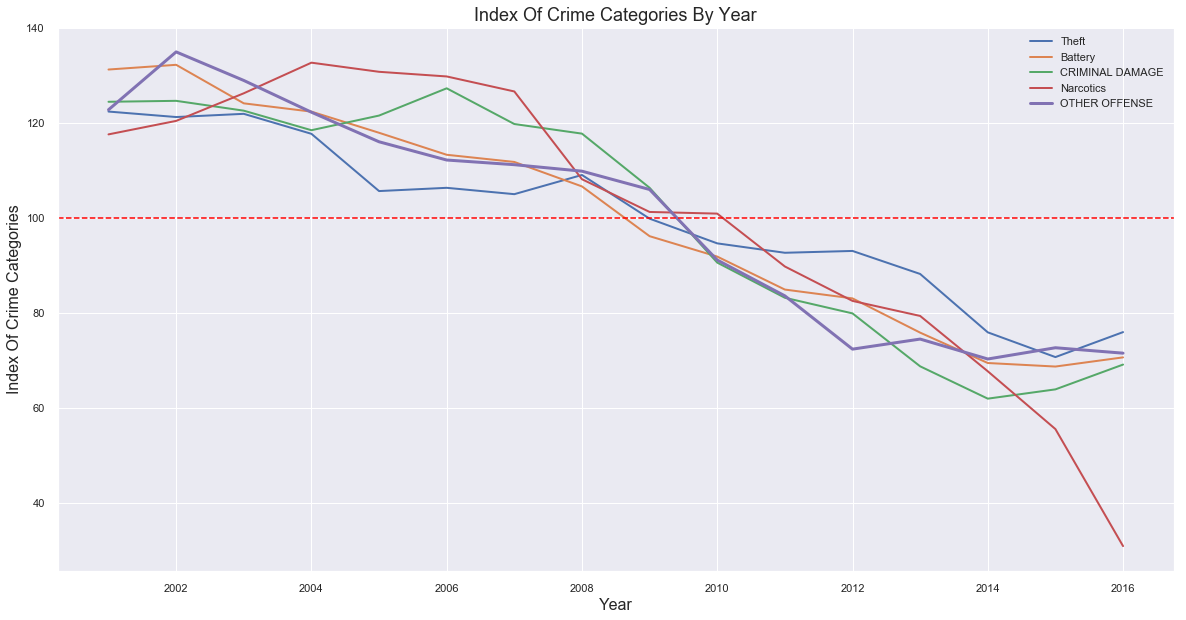

In [22]:
(crimes[(crimes['Primary Type'] == "THEFT") & (crimes['Date'] < '2017')].groupby('Year')['Counter'].aggregate(np.sum) / \
crimes[(crimes['Primary Type'] == "THEFT") & (crimes['Date'] < '2017')].groupby('Year')['Counter'].aggregate(np.sum).mean() * 100).plot(linewidth=2)

(crimes[(crimes['Primary Type'] == "BATTERY") & (crimes['Date'] < '2017')].groupby('Year')['Counter'].aggregate(np.sum) / \
crimes[(crimes['Primary Type'] == "BATTERY") & (crimes['Date'] < '2017')].groupby('Year')['Counter'].aggregate(np.sum).mean() * 100).plot(linewidth=2)

(crimes[(crimes['Primary Type'] == "CRIMINAL DAMAGE") & (crimes['Date'] < '2017')].groupby('Year')['Counter'].aggregate(np.sum) / \
crimes[(crimes['Primary Type'] == "CRIMINAL DAMAGE") & (crimes['Date'] < '2017')].groupby('Year')['Counter'].aggregate(np.sum).mean() * 100).plot(linewidth=2)

(crimes[(crimes['Primary Type'] == "NARCOTICS") & (crimes['Date'] < '2017')].groupby('Year')['Counter'].aggregate(np.sum) / \
 crimes[(crimes['Primary Type'] == "NARCOTICS") & (crimes['Date'] < '2017')].groupby('Year')['Counter'].aggregate(np.sum).mean() * 100).plot(linewidth=2)

(crimes[(crimes['Primary Type'] == "OTHER OFFENSE") & (crimes['Date'] < '2017')].groupby('Year')['Counter'].aggregate(np.sum) / \
crimes[(crimes['Primary Type'] == "OTHER OFFENSE") & (crimes['Date'] < '2017')].groupby('Year')['Counter'].aggregate(np.sum).mean() * 100).plot(figsize=(20, 10), linewidth=3)

plt.title('Index Of Crime Categories By Year', fontsize=18)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Index Of Crime Categories', fontsize=16)
plt.legend(['Theft', 'Battery', 'CRIMINAL DAMAGE','Narcotics', 'OTHER OFFENSE'])
plt.axhline(100, color='red', linestyle='--')

### Crime Hours

In [23]:
ranges = [0,6,12,18,24]
labels = ['Early Morning','Morning','Early Afternoon','Evening']
crimes['Time_Group'] = pd.cut(crimes['crime_hour'],ranges, labels=labels).astype('category')

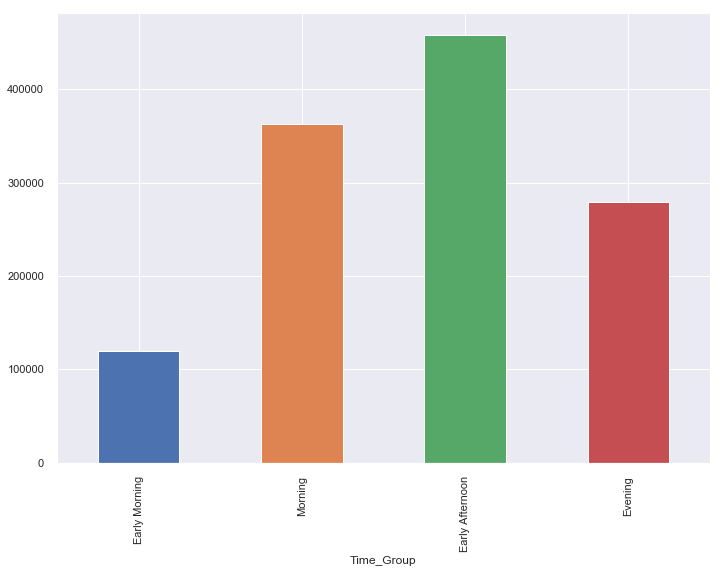

In [24]:
theft_hours = crimes[crimes['Primary Type'] == 'THEFT']
theft_hours.groupby('Time_Group')['Primary Type'].count().plot(kind='bar')

The most popular hours for crime are 8PM, 7PM, and 12PM. Interesting that we see a spike in the middle of the day compared to other hours. Crime is very low during the early morning periods from 1AM to 5AM likely because most people are still asleep.

Text(0,0.5,'Number of Crimes')

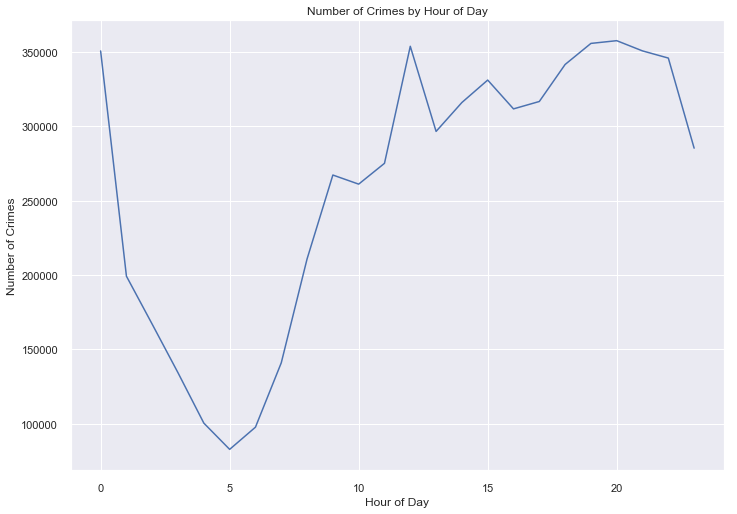

In [25]:
timer = crimes['crime_hour'].value_counts()
df_hour = timer.to_frame()
df_hour.sort_index().plot( legend = False, title = "Number of Crimes by Hour of Day")
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')

In [26]:
theft_time = crimes[crimes['Primary Type'] == 'THEFT']
battery_time = crimes[crimes['Primary Type'] == 'BATTERY']
crimedamage_time = crimes[crimes['Primary Type'] == 'CRIMINAL DAMAGE']
narcos_time = crimes[crimes['Primary Type'] == 'NARCOTICS']
otheroffence_time = crimes[crimes['Primary Type'] == 'OTHER OFFENSE']

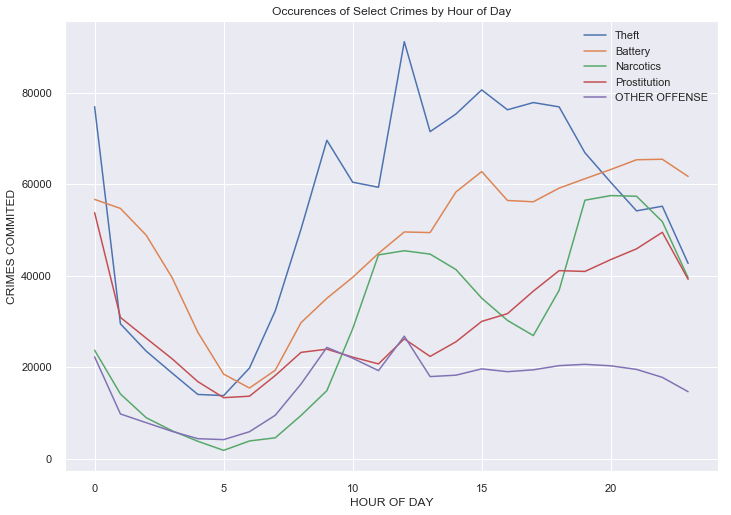

In [27]:
theft_time.groupby('crime_hour')['Primary Type'].count().plot( title = 'Occurences of Select Crimes by Hour of Day')
battery_time.groupby('crime_hour')['Primary Type'].count().plot()
narcos_time.groupby('crime_hour')['Primary Type'].count().plot()
crimedamage_time.groupby('crime_hour')['Primary Type'].count().plot()
otheroffence_time.groupby('crime_hour')['Primary Type'].count().plot()
plt.xlabel('HOUR OF DAY')
plt.ylabel('CRIMES COMMITED')
plt.legend(('Theft', 'Battery', 'Narcotics', 'Prostitution','OTHER OFFENSE',), loc = 'best')

In [28]:
loc_to_change  = list(crimes['Location Description'].value_counts()[20:].index)
desc_to_change = list(crimes['Description'].value_counts()[20:].index)
#type_to_change = list(crimes['Primary Type'].value_counts()[20:].index)

crimes.loc[crimes['Location Description'].isin(loc_to_change) , crimes.columns=='Location Description'] = 'OTHER'
crimes.loc[crimes['Description'].isin(desc_to_change) , crimes.columns=='Description'] = 'OTHER'

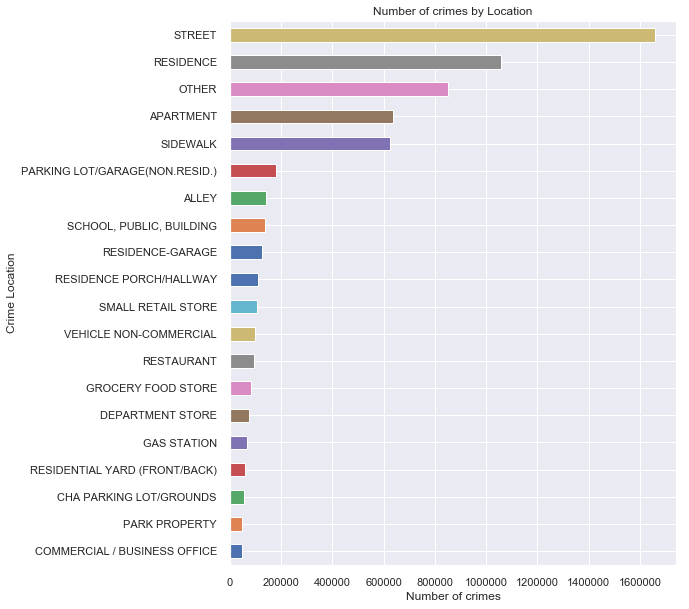

In [29]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Location Description']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Location')
plt.ylabel('Crime Location')
plt.xlabel('Number of crimes')
plt.show()

In [30]:
crime_activity = pd.DataFrame(crimes.groupby('Year').size().rename('Count').reset_index())
crime_activity
arrest = crimes[['Year','Arrest']]
arrest_new = arrest[arrest['Arrest'] == True]
arrest_activity = pd.DataFrame(arrest_new.groupby('Year').size().rename('Count').reset_index())
arrest_activity

,Year,Count
0,2001,141902
1,2002,141550
2,2003,141571
3,2004,144683
4,2005,140895
5,2006,135379
6,2007,131848
7,2008,109950
8,2009,110761
9,2010,100471


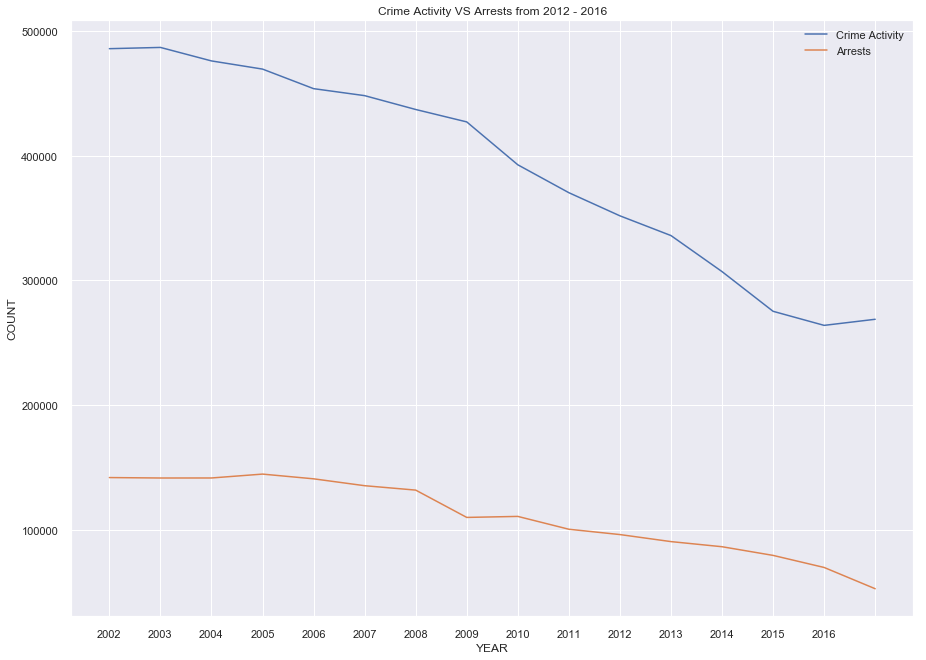

In [31]:
import matplotlib.ticker as ticker
x=['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016']
y=crime_activity['Count']
z=arrest_activity['Count']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.plot(x,y,label='Crime Activity')
ax.plot(x,z,label='Arrests')
ax.set_ylabel("COUNT")
ax.set_xlabel("YEAR")
ax.set_title("Crime Activity VS Arrests from 2012 - 2016")
ax.legend()

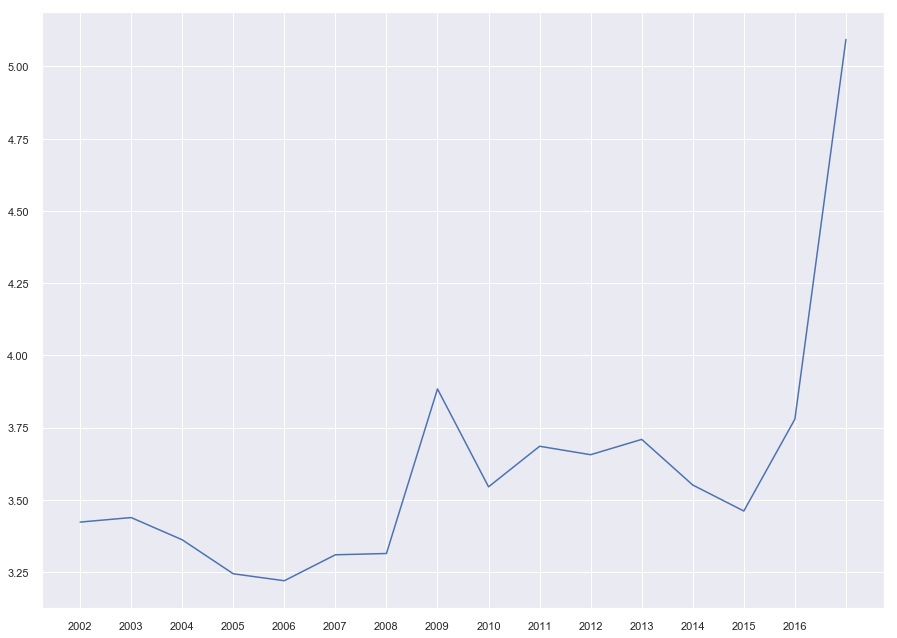

In [32]:
x=['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016']
k = y/z
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.plot(x,k,label='Crime Arrest Ratio')

## Crime Location Cluster 

In [33]:
crimes.head(2)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,...,Longitude,Location,Year,crime_hour,Month,Day,DoW,Datestr,Counter,Time_Group
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-18 19:44:00,10000092,2015-03-18 19:44:00,047XX W OHIO ST,BATTERY,OTHER,STREET,False,False,1111,11.0,...,-87.744385,"(41.891398861, -87.744384567)",2015,19,3,18,2,2015-03-18,1,Evening
2015-03-18 23:00:00,10000094,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,OTHER OFFENSE,OTHER,STREET,True,False,725,7.0,...,-87.665319,"(41.773371528, -87.665319468)",2015,23,3,18,2,2015-03-18,1,Evening


In [34]:
unique_locations = crimes['Location'].value_counts()
Time_Group = crimes['Time_Group']
CR_index = pd.DataFrame({"Raw_String" : unique_locations.index, "ValueCount":unique_locations })
CR_index.index = range(len(unique_locations))
CR_index.head()

,Raw_String,ValueCount
0,"(41.976290414, -87.905227221)",12610
1,"(41.754592961, -87.741528537)",8986
2,"(41.883500187, -87.627876698)",6046
3,"(41.897895128, -87.624096605)",3771
4,"(41.896888586, -87.628203192)",2923


In [35]:
def Location_extractor(Raw_Str):
    preProcess = Raw_Str[1:-1].split(',')
    lat =  float(preProcess[0])
    long = float(preProcess[1])
    return (lat, long)

In [36]:
CR_index['LocationCoord'] = CR_index['Raw_String'].apply(Location_extractor)
CR_index  = CR_index.drop(columns=['Raw_String'], axis = 1)

In [37]:
%%time

chicago_map_crime = folium.Map(location=[41.895140898, -87.624255632],
                        zoom_start=11)

for i in range(500):
    lat = CR_index['LocationCoord'].iloc[i][0]
    long = CR_index['LocationCoord'].iloc[i][1]
    radius = CR_index['ValueCount'].iloc[i] / 100
    
    if CR_index['ValueCount'].iloc[i] > 2000:
        color = "red"
    else:
        color = "Blue"
    
    popup_text = """Latitude : {}<br>
                Longitude : {}<br>
                Criminal Incidents : {}<br>"""
    popup_text = popup_text.format(lat,
                               long,
                               CR_index['ValueCount'].iloc[i]
                               )
    folium.CircleMarker(location = [lat, long], popup= popup_text,radius = radius, color = color, fill = True).add_to(chicago_map_crime)


Wall time: 179 ms


In [38]:
chicago_map_crime

### Analysing Airport Data 

In [39]:
crime_airpot = crimes[(crimes['Longitude'] ==  -87.905227221) & ( crimes['Latitude'] == 41.976290414)]

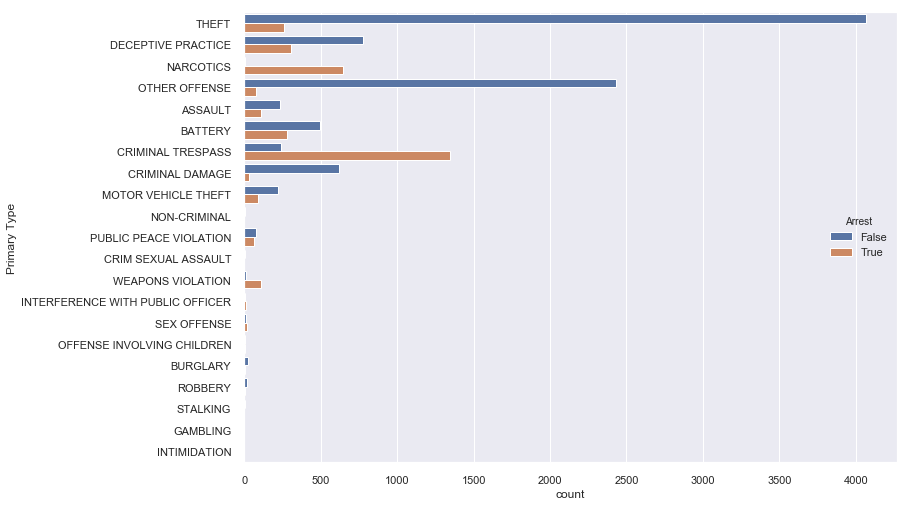

In [40]:
sns.countplot(y="Primary Type", hue="Arrest", data=crime_airpot)

In [41]:
crime_airpot.head(2)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,...,Longitude,Location,Year,crime_hour,Month,Day,DoW,Datestr,Counter,Time_Group
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-19 16:00:00,10001713,2015-03-19 16:00:00,100XX W OHARE ST,THEFT,OVER $500,STREET,False,False,1651,16.0,...,-87.905227,"(41.976290414, -87.905227221)",2015,16,3,19,3,2015-03-19,1,Early Afternoon
2015-03-19 17:30:00,10002427,2015-03-19 17:30:00,100XX W OHARE ST,THEFT,FROM BUILDING,OTHER,False,False,1651,16.0,...,-87.905227,"(41.976290414, -87.905227221)",2015,17,3,19,3,2015-03-19,1,Early Afternoon


In [42]:
crimes['Location Description'].value_counts().head(5)

STREET       1659329
RESIDENCE    1058745
OTHER         852339
APARTMENT     634578
SIDEWALK      625737
Name: Location Description, dtype: int64

## Analysing Crimes by Police Station Location 

In [43]:
Police_Station.rename(index=str, columns={"DISTRICT_Police": "District"} , inplace=True)
crimes.dropna(subset=['District'] , inplace=True)
crimes['District'] = crimes['District'].astype(int)
Police_Station['District'] = Police_Station['District'].astype(int)
crime_police = pd.merge(crimes, Police_Station, on = 'District', how = 'left')

In [44]:
crime_police.head(2)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,...,ZIP_Police,WEBSITE_Police,PHONE_Police,FAX_Police,TTY_Police,X COORDINATE_Police,Y COORDINATE_Police,LATITUDE_Police,LONGITUDE_Police,LOCATION_Police
0,10000092,2015-03-18 19:44:00,047XX W OHIO ST,BATTERY,OTHER,STREET,False,False,1111,11,...,60612.0,{'url': 'http://home.chicagopolice.org/communi...,312-746-8386,312-746-4281,312-746-5151,1155244.069,1897148.755,41.873582,-87.705488,"{'needs_recoding': False, 'longitude': '-87.70..."
1,10000094,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,OTHER OFFENSE,OTHER,STREET,True,False,725,7,...,60636.0,{'url': 'http://home.chicagopolice.org/communi...,312-747-8223,312-747-6558,312-747-6652,1167659.235,1863005.522,41.779632,-87.660887,"{'needs_recoding': False, 'longitude': '-87.66..."


In [45]:
def distance(s_lat, s_lng, e_lat, e_lng):
    
    # approximate radius of earth in km
    R = 3959.0
    
    s_lat = s_lat*np.pi/180.0                      
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  
    
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    
    return 2 * R * np.arcsin(np.sqrt(d)) 

In [46]:
crime_police['Crime_police_dist']  = distance(crime_police['Latitude'] , crime_police['Longitude'] , crime_police['LATITUDE_Police'], crime_police['LONGITUDE_Police'])

In [47]:
crime_police.dropna(subset=['Crime_police_dist'] , inplace=True)
crime_police['Crime_police_dist']  = round(crime_police['Crime_police_dist'])
x = crime_police.groupby(['District' ])['Crime_police_dist'].mean().reset_index()
y = crime_police.groupby(['District' ])['ID'].count().reset_index()
z = pd.merge(x, y, on = 'District', how = 'left')
temp1 = crime_police.groupby('Location')['ID'].count().reset_index(name='count').sort_values(['count'], ascending=False) 
temp1 = temp1[temp1['count'] > 2000]
temp2 = crime_police[crime_police['Location'].isin(temp1['Location'])]

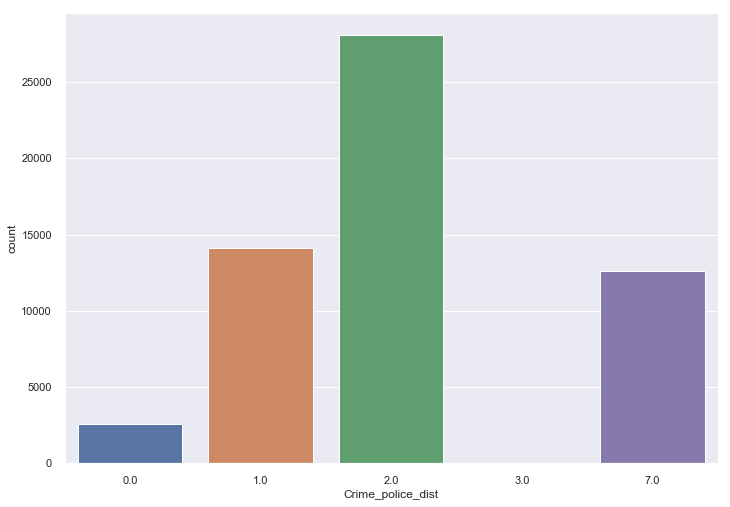

In [48]:
sns.countplot(temp2['Crime_police_dist'])

In [49]:
print(len(temp2[temp2['Crime_police_dist'] <= 2]))
print(len(temp2[temp2['Crime_police_dist'] > 2]))

44818
12612


[(0, 1)]

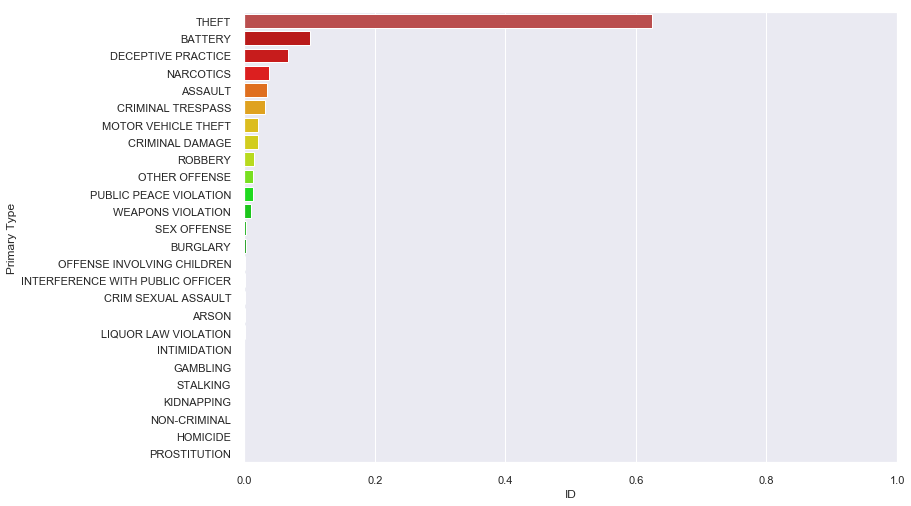

In [50]:
temp3 = temp2[temp2['Crime_police_dist'] == 2].groupby('Primary Type')['ID'].count().reset_index().sort_values('ID' , ascending=False)
ax = sns.barplot(temp3['ID']/28140,temp3['Primary Type'] ,palette='nipy_spectral_r' )
ax.set(xlim=(0, 1))

[(0, 1)]

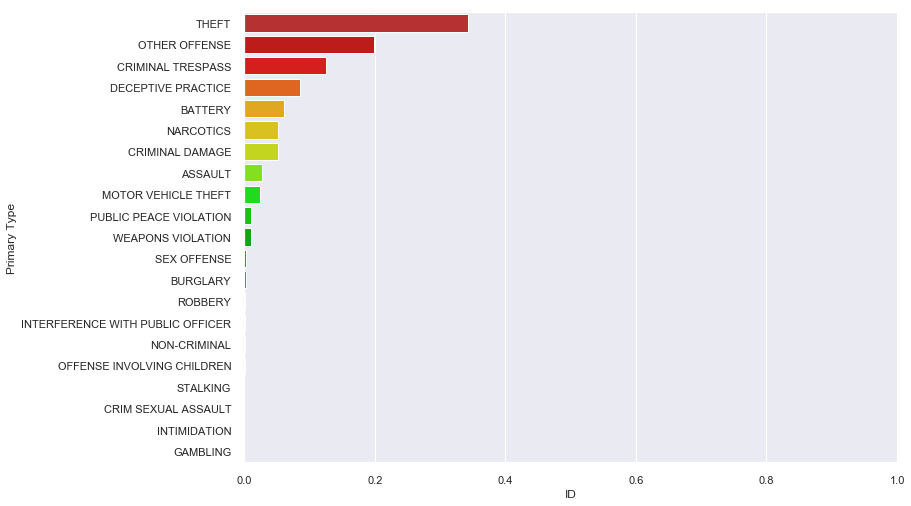

In [51]:
temp4 = temp2[temp2['Crime_police_dist'] == 7].groupby('Primary Type')['ID'].count().reset_index().sort_values('ID' , ascending=False)
ax1 = sns.barplot(temp4['ID']/12610,temp4['Primary Type'] ,palette='nipy_spectral_r' )
ax1.set(xlim=(0, 1))

There is significant evidence that if there is increase in the distance from a police station then chances of other crimes will significatly increase

## Crime and Socioeconomic Factors  - 2010 Data 

We setup a new dataframe for the socioeconomic comparison. First we filtered the crime dataset for only crimes commited in 2010. Then we merged the population and socioeconomic data to get the crime_pop_socio dataframe

In [52]:
df_2010 = crimes[crimes.Year == 2010]
crimes_by_ca = df_2010.groupby('Community Area')['Community Area'].count()
crimes_by_ca = crimes_by_ca.to_frame('Crimes')
crimes_by_ca['Num'] = crimes_by_ca.index

In [53]:
crime_pop = pd.merge(crimes_by_ca, population, on = 'Num', how = 'left')
crime_pop.dropna(inplace=True)
socio.rename(columns = {'Community Area Number':'Num'}, inplace = True)
crime_pop_socio = pd.merge(crime_pop, socio, on = 'Num', how = 'left')

In [54]:
crime_pop_socio = crime_pop_socio.dropna()

In [55]:
crime_pop_socio.dtypes

Crimes                                            int64
Num                                             float64
Community Area                                   object
2010                                            float64
2000                                            float64
Difference                                      float64
Percentage                                       object
COMMUNITY AREA NAME                              object
PERCENT OF HOUSING CROWDED                      float64
PERCENT HOUSEHOLDS BELOW POVERTY                float64
PERCENT AGED 16+ UNEMPLOYED                     float64
PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA    float64
PERCENT AGED UNDER 18 OR OVER 64                float64
PER CAPITA INCOME                                 int64
HARDSHIP INDEX                                  float64
dtype: object

In [56]:
crime_pop_socio['Difference'].unique()

array([ -8493.,  -1257.,  -7189.,  -5081.,    -28.,   -449.,   -204.,
         7673.,    -72.,   -646.,   -411.,    343.,   -583.,  -6113.,
        -1216.,  -5284.,   -232.,    780.,    599.,  -1898.,  -3821.,
        -9120.,  -9513.,  -6003., -19013.,  -5018.,   -314.,   8462.,
        -5856., -11783.,  -8262.,  12895.,  11881.,   1359.,  -8232.,
         -192.,   -544.,  -6077.,   -522.,  -2429.,  -4239.,  -1103.,
       -11789.,  -6247.,   -962.,  -7398.,   -378.,  -2162.,  -8104.,
        -1596.,  -1881.,   -611.,  -6998.,  -3327.,   -355.,  -1588.,
          749.,    456.,   -350.,  -1717.,  -7344.,   2188.,    701.,
          808.,   4120.,  -5784.,  -9777.,  -9568.,  -6017.,   1497.,
        -7185.,  -1958.,  -3350.,    273.,  -2682.,    800.,  -5677.])

In [57]:
crime_pop_socio['Difference']  = crime_pop_socio['Difference'].astype(int)

In [58]:
crime_pop_socio[crime_pop_socio['2010'] > crime_pop_socio['2000']]

,Crimes,Num,Community Area,2010,2000,Difference,Percentage,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
7,11594,8.0,Near North Side,80484.0,72811.0,7673,10.50%,Near North Side,1.9,12.9,7.0,2.5,22.6,88669,1.0
11,695,12.0,Forest Glen,18508.0,18165.0,343,1.90%,Forest Glen,1.1,7.5,6.8,4.9,40.5,44164,11.0
17,899,18.0,Montclare,13426.0,12646.0,780,6.20%,Montclaire,8.1,15.3,13.8,23.5,38.6,22014,50.0
18,7588,19.0,Belmont Cragin,78743.0,78144.0,599,0.80%,Belmont Cragin,10.8,18.7,14.6,37.3,37.3,15461,70.0
27,9810,28.0,Near West Side,54881.0,46419.0,8462,18.20%,Near West Side,3.8,20.6,10.7,9.6,22.2,44689,15.0
31,7840,32.0,Loop,29283.0,16388.0,12895,78.70%,Loop,1.5,14.7,5.7,3.1,13.5,65526,3.0
32,1999,33.0,Near South Side,21390.0,9509.0,11881,124.90%,Near South Side,1.3,13.8,4.9,7.4,21.8,59077,7.0
33,1368,34.0,Armour Square,13391.0,12032.0,1359,11.30%,Armour Square,5.7,40.1,16.7,34.5,38.3,16148,82.0
56,1356,57.0,Archer Heights,13393.0,12644.0,749,5.90%,Archer Heights,8.5,14.1,16.5,35.9,39.2,16134,67.0
57,3532,58.0,Brighton Park,45368.0,44912.0,456,1.00%,Brighton Park,14.4,23.6,13.9,45.1,39.3,13089,84.0


### to get a crime rate we created the crime per 100 persons column

[(0, 50)]

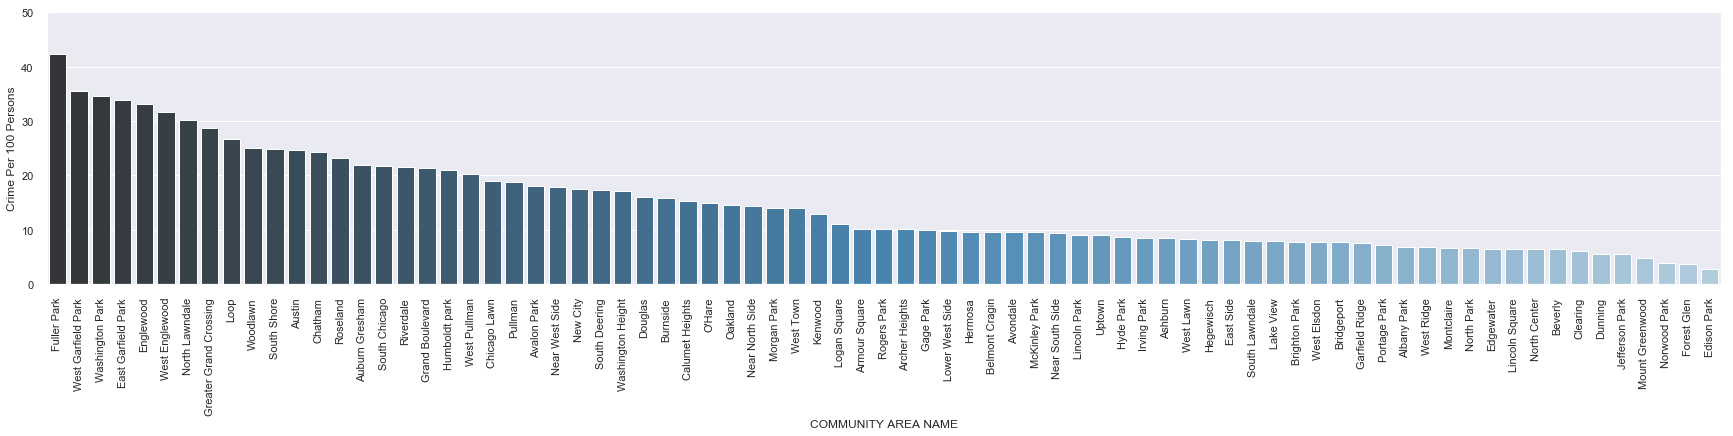

In [59]:
crime_pop_socio['Crime Per 100 Persons'] = crime_pop_socio['Crimes']/crime_pop_socio['2010']*100
temp2 = crime_pop_socio[crime_pop_socio['Num'] > 0].sort_values('Crime Per 100 Persons' , ascending=False)
sns.set(rc={'figure.figsize':(30,5)})
ax = sns.barplot('COMMUNITY AREA NAME', y='Crime Per 100 Persons', data=temp2, palette="Blues_d" )
plt.setp( ax.get_xticklabels(), rotation=90)
ax.set(ylim=(0, 50))

[(0, 50)]

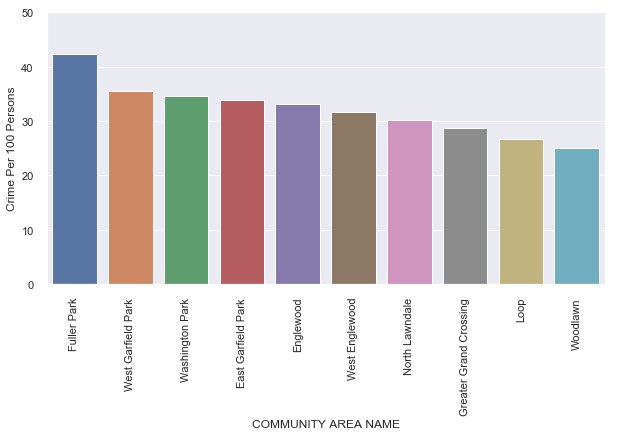

In [60]:
temp2_1 = temp2.head(10)
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.barplot('COMMUNITY AREA NAME', y='Crime Per 100 Persons', data=temp2_1 )
plt.setp( ax.get_xticklabels(), rotation=90)
ax.set(ylim=(0, 50))

#### Crime rate in the Fuller Park Neighborhood is very high with 42.24 incidents of crime per every 100 persons

[(0, 50)]

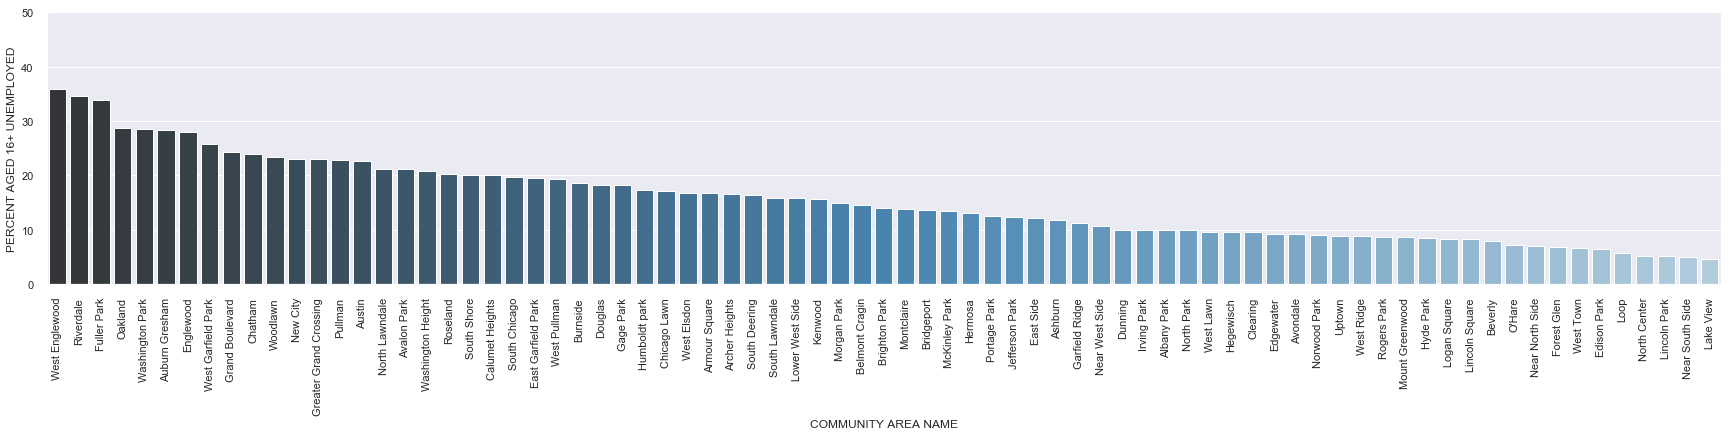

In [61]:
temp3 = crime_pop_socio[crime_pop_socio['Num'] > 0].sort_values('PERCENT AGED 16+ UNEMPLOYED' , ascending=False)
sns.set(rc={'figure.figsize':(30,5)})
ax = sns.barplot('COMMUNITY AREA NAME', y='PERCENT AGED 16+ UNEMPLOYED', data=temp3, palette="Blues_d" )
plt.setp( ax.get_xticklabels(), rotation=90)
ax.set(ylim=(0, 50))

[(0, 50)]

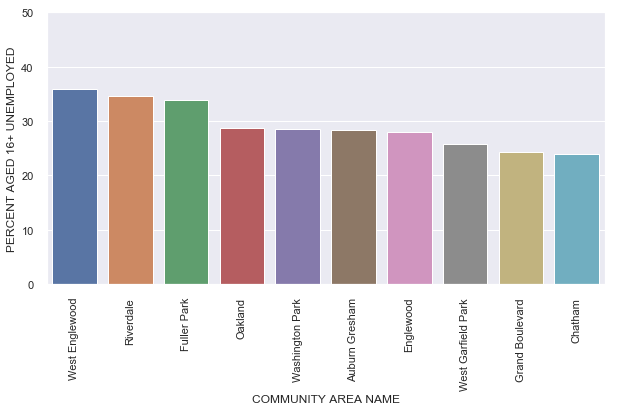

In [62]:
temp3_1 = temp3.head(10)
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.barplot('COMMUNITY AREA NAME', y='PERCENT AGED 16+ UNEMPLOYED', data=temp3_1 )
plt.setp( ax.get_xticklabels(), rotation=90)
ax.set(ylim=(0, 50))

In [63]:
np.intersect1d(temp3_1['Community Area'] , temp2_1['Community Area'])

array(['Englewood', 'Fuller Park', 'Washington Park', 'West Englewood',
       'West Garfield Park'], dtype=object)

[(0, 50)]

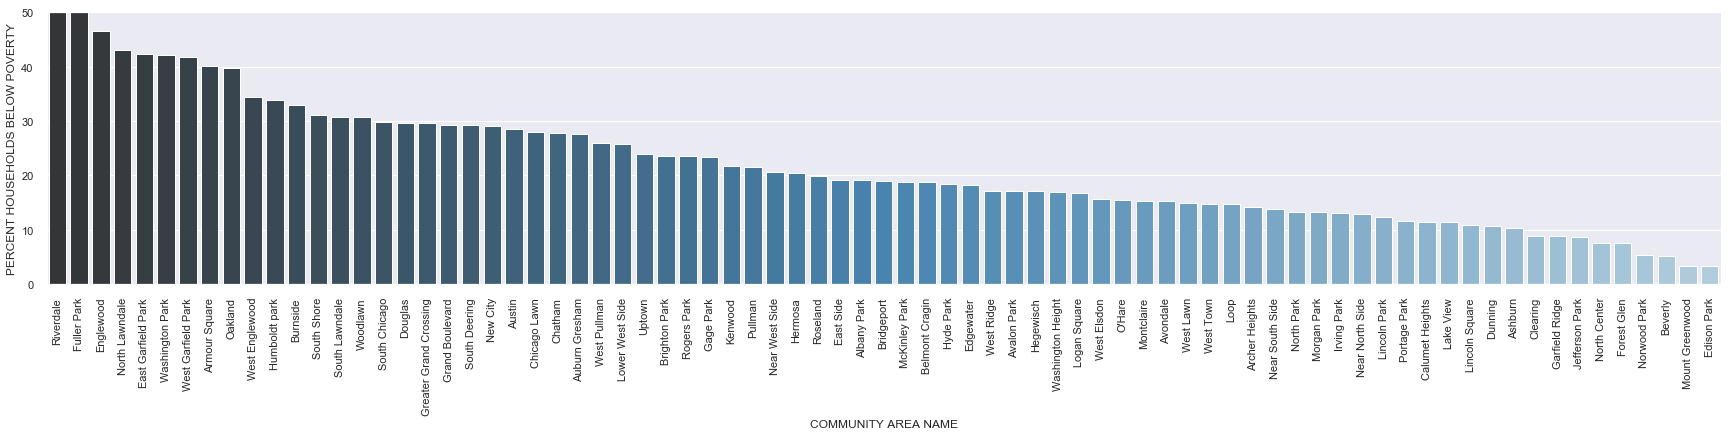

In [64]:
temp4 = crime_pop_socio[crime_pop_socio['Num'] > 0].sort_values('PERCENT HOUSEHOLDS BELOW POVERTY' , ascending=False)
sns.set(rc={'figure.figsize':(30,5)})
ax = sns.barplot('COMMUNITY AREA NAME', y='PERCENT HOUSEHOLDS BELOW POVERTY', data=temp4, palette="Blues_d" )
plt.setp( ax.get_xticklabels(), rotation=90)
ax.set(ylim=(0, 50))


Text(0,0.5,'Percent Aged 16+ Unemployed')

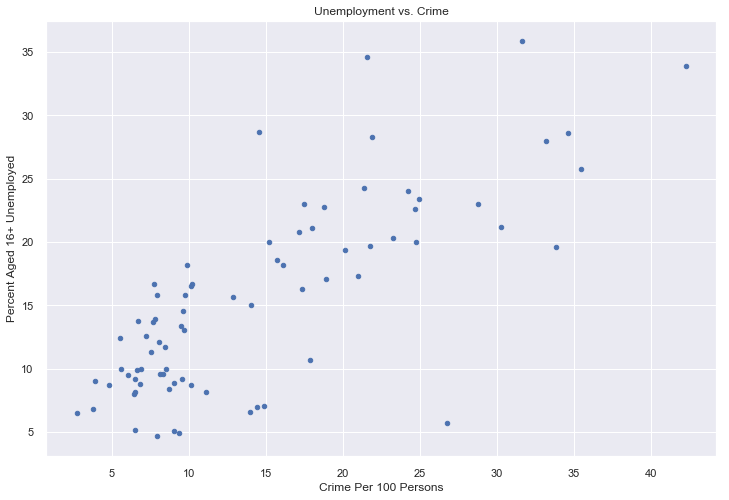

In [65]:
crime_pop_socio.plot(x='Crime Per 100 Persons', y = 'PERCENT AGED 16+ UNEMPLOYED', kind='scatter', figsize = (12,8), title = 'Unemployment vs. Crime')
plt.xlabel('Crime Per 100 Persons')
plt.ylabel('Percent Aged 16+ Unemployed')

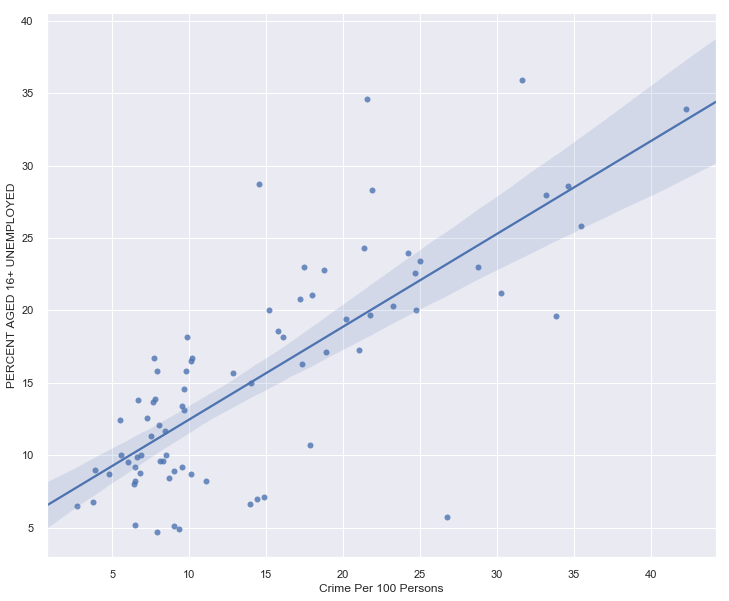

In [66]:
sns.set(rc={'figure.figsize':(12,10)})
sns.regplot(crime_pop_socio['Crime Per 100 Persons'] , crime_pop_socio['PERCENT AGED 16+ UNEMPLOYED'])

In [67]:
np.corrcoef(crime_pop_socio['Crime Per 100 Persons'] , crime_pop_socio['PERCENT AGED 16+ UNEMPLOYED'])

array([[1.        , 0.76357887],
       [0.76357887, 1.        ]])

### Looks like we have a fairly strong positive correlation between crimes per person and unemployment rate

Text(0,0.5,'Percent Households Below Poverty')

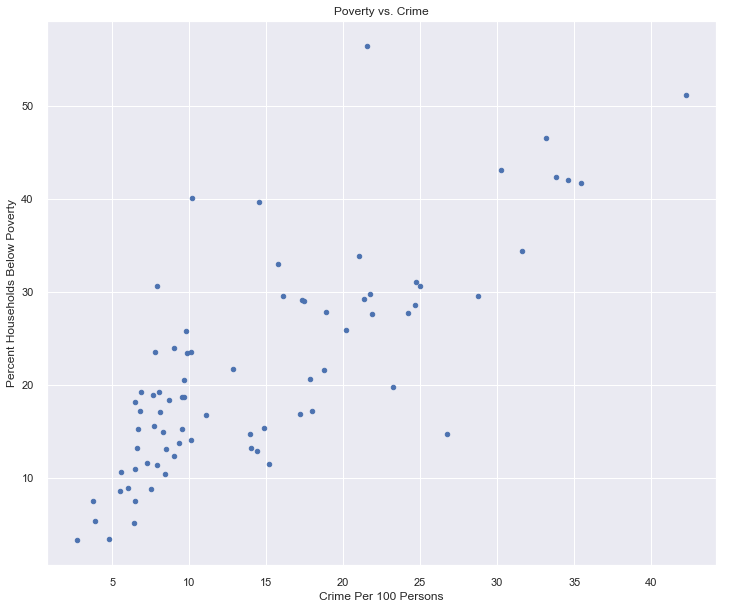

In [68]:
crime_pop_socio.plot(x='Crime Per 100 Persons', y = 'PERCENT HOUSEHOLDS BELOW POVERTY', kind='scatter',  title = 'Poverty vs. Crime')
plt.xlabel('Crime Per 100 Persons')
plt.ylabel('Percent Households Below Poverty')

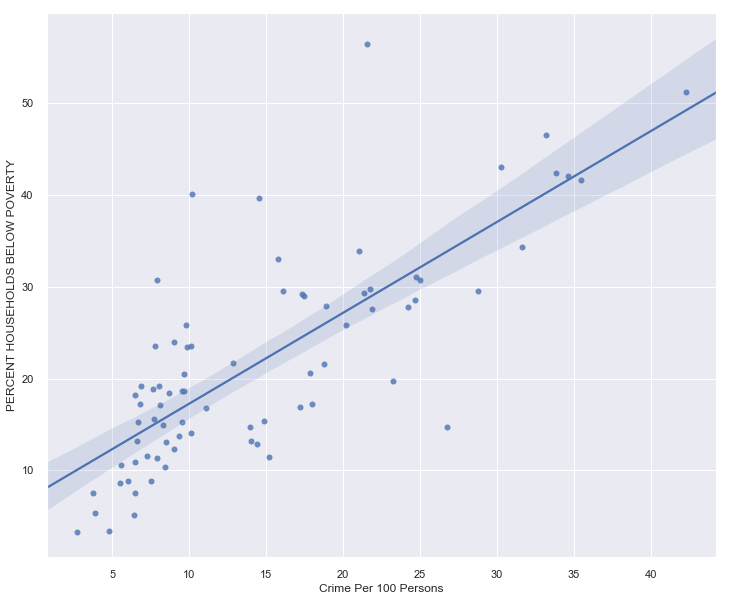

In [69]:
sns.regplot(crime_pop_socio['Crime Per 100 Persons'] , crime_pop_socio['PERCENT HOUSEHOLDS BELOW POVERTY'])

In [70]:
np.corrcoef(crime_pop_socio['Crime Per 100 Persons'] , crime_pop_socio['PERCENT HOUSEHOLDS BELOW POVERTY'])

array([[1.        , 0.77139451],
       [0.77139451, 1.        ]])

In [71]:
crime_pop_socio.columns
corr_crime_unemployment = crime_pop_socio[['Crime Per 100 Persons','PERCENT AGED 16+ UNEMPLOYED','PERCENT HOUSEHOLDS BELOW POVERTY','PERCENT OF HOUSING CROWDED','PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA','PER CAPITA INCOME ','HARDSHIP INDEX']]

In [72]:
correl_all = corr_crime_unemployment.corr()

In [73]:
correl_all[0:1]

,Crime Per 100 Persons,PERCENT AGED 16+ UNEMPLOYED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT OF HOUSING CROWDED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PER CAPITA INCOME,HARDSHIP INDEX
Crime Per 100 Persons,1.0,0.763579,0.771395,0.00782,0.079402,-0.337683,0.550905


Text(0,0.5,'Per Capita Income')

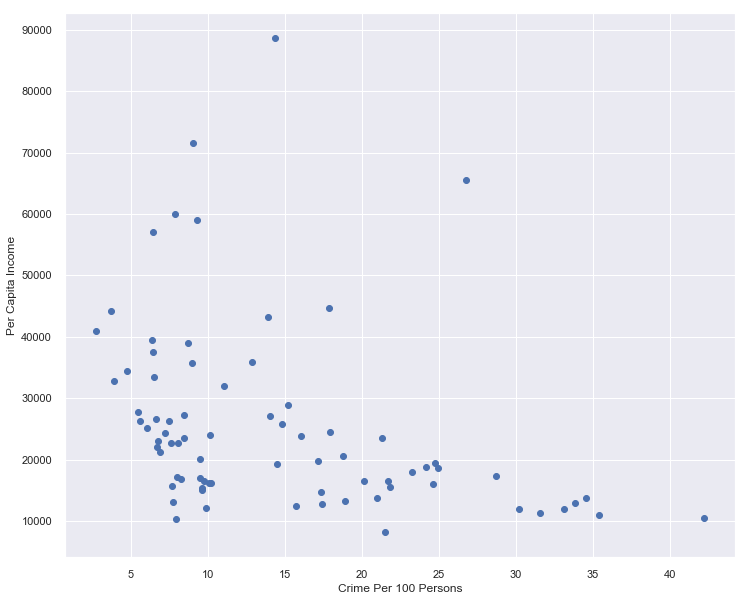

In [74]:
plt.scatter(crime_pop_socio['Crime Per 100 Persons'], crime_pop_socio['PER CAPITA INCOME '])
plt.xlabel('Crime Per 100 Persons')
plt.ylabel('Per Capita Income')

### Positive correlation between crime and percent of housing crowded

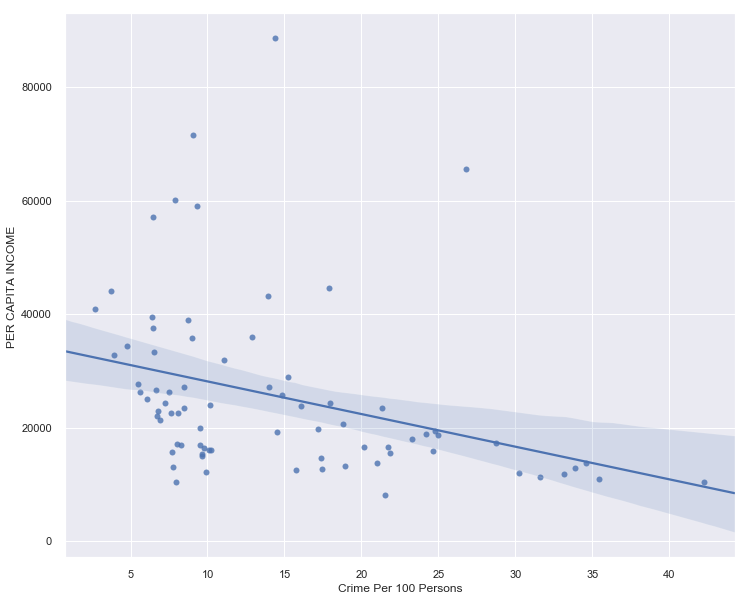

In [75]:
sns.regplot(crime_pop_socio['Crime Per 100 Persons'] , crime_pop_socio['PER CAPITA INCOME '])

### Weather Analysis on Crime 

In [76]:
weather = pd.read_csv('D:\\Data Science\\Clarity Insigts\\weather.csv')
weather.head()

,station,year,month,element,day,value
0,110072,1901,1,TMAX,1,27.0
1,110072,1901,1,TMAX,2,34.0
2,110072,1901,1,TMAX,3,41.0
3,110072,1901,1,TMAX,4,33.0
4,110072,1901,1,TMAX,5,40.0


In [77]:
weather = weather[weather['year'] > 2000]

In [78]:
aurora = weather[(weather['station'] == 110338) & (weather['year'] >= 2001) & (weather['value'] != -9999)].dropna()
aurora['Date'] = aurora.year.astype(str) + '-' + aurora.month.astype(str) + '-' + aurora.day.astype(str)
aurora['Datetime'] = pd.to_datetime(aurora.Date)
aurora.head()

,station,year,month,element,day,value,Date,Datetime
615505,110338,2001,1,TMAX,1,17.0,2001-1-1,2001-01-01
615506,110338,2001,1,TMAX,2,29.0,2001-1-2,2001-01-02
615507,110338,2001,1,TMAX,3,33.0,2001-1-3,2001-01-03
615508,110338,2001,1,TMAX,4,38.0,2001-1-4,2001-01-04
615509,110338,2001,1,TMAX,5,37.0,2001-1-5,2001-01-05


In [79]:
aurora[aurora['element'] == 'TMAX'].set_index('Datetime').head()
crimes_byday = crimes[['Counter', 'Datestr']].groupby('Datestr').aggregate(np.sum)
crime_temp = crimes_byday.join(aurora[aurora['element'] == 'TMAX'].set_index('Datetime')['value'], how='inner')
crime_temp.columns = ['Crime', 'Temp']
crime_temp.head()

,Crime,Temp
2001-01-01,1814,17.0
2001-01-02,1143,29.0
2001-01-03,1151,33.0
2001-01-04,1166,38.0
2001-01-05,1267,37.0


In [80]:
crime_temp.corr()

,Crime,Temp
Crime,1.000000,0.419223
Temp,0.419223,1.000000


Float64Index([-11.0,  -5.0,  -3.0,   2.0,   3.0,   4.0,   6.0,   7.0,   8.0,
                9.0,
              ...
               92.0,  93.0,  94.0,  95.0,  96.0,  97.0,  98.0,  99.0, 101.0,
              103.0],
             dtype='float64', name='Temp', length=102)


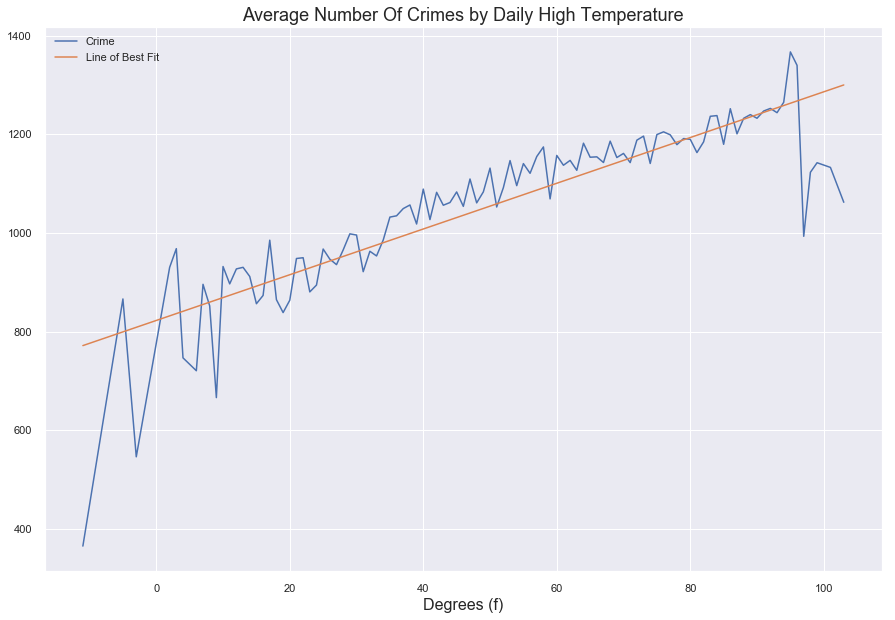

In [81]:
crime_temp.groupby('Temp').aggregate(np.mean).plot(figsize=(15,10))
x = crime_temp.groupby('Temp').aggregate(np.mean).index
y = crime_temp.groupby('Temp').aggregate(np.mean)
print(x)
m, b = np.polyfit(x, y , 1)
plt.plot(x, np.array([m*xx + b for xx in x]))
plt.title('Average Number Of Crimes by Daily High Temperature', fontsize=18)
plt.xlabel('Degrees (f)', fontsize=16)
plt.ylabel('', fontsize=16)
plt.legend(['Crime', 'Line of Best Fit'])

# Machine Learning Models 

In [82]:
crimes.head(1)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,...,Longitude,Location,Year,crime_hour,Month,Day,DoW,Datestr,Counter,Time_Group
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-18 19:44:00,10000092,2015-03-18 19:44:00,047XX W OHIO ST,BATTERY,OTHER,STREET,False,False,1111,11,...,-87.744385,"(41.891398861, -87.744384567)",2015,19,3,18,2,2015-03-18,1,Evening


In [83]:
crime_police.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6192528 entries, 0 to 6249162
Data columns (total 38 columns):
ID                      int64
Date                    datetime64[ns]
Block                   object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                int32
Ward                    float64
Community Area          float64
Latitude                float64
Longitude               float64
Location                object
Year                    int64
crime_hour              int64
Month                   int64
Day                     int64
DoW                     int64
Datestr                 datetime64[ns]
Counter                 int64
Time_Group              category
DISTRICT NAME_Police    object
ADDRESS_Police          object
CITY_Police             object
STATE_Police            object
ZIP_Police              float64
WEBSITE_P

In [84]:
ML_Crime= crime_police[['Primary Type' , 'Location Description' , 'Domestic' , 'Year' ,'Time_Group' , 'Month' , 'District' ,'ZIP_Police' ,'Crime_police_dist' ,'Arrest'  ]].reset_index()
ML_Crime.dropna(inplace=True)

In [85]:
ML_Crime.head(3)

,index,Primary Type,Location Description,Domestic,Year,Time_Group,Month,District,ZIP_Police,Crime_police_dist,Arrest
0,0,BATTERY,STREET,False,2015,Evening,3,11,60612.0,2.0,False
1,1,OTHER OFFENSE,STREET,False,2015,Evening,3,7,60636.0,0.0,True
2,2,BATTERY,APARTMENT,True,2015,Evening,3,2,60609.0,2.0,False


In [86]:
ML_Crime = ML_Crime[ML_Crime['Year'] > 2012] 

In [87]:
x = ML_Crime[['Primary Type' , 'Location Description' , 'Domestic' , 'Year' ,'Time_Group' , 'Month' , 'District' ,'ZIP_Police' ,'Crime_police_dist']]
y = ML_Crime['Arrest']

In [88]:
Primary_Type = LabelEncoder()
Location_Description = LabelEncoder()
Domestic = LabelEncoder()
Year = LabelEncoder()
Time_Group = LabelEncoder()
Month = LabelEncoder()
District = LabelEncoder()
ZIP_Police = LabelEncoder()
Crime_police_dist = LabelEncoder()

In [89]:
transformed = pd.DataFrame(columns=['Primary_Type' , 'Location_Description' , 'Domestic' , 'Year' ,'Time_Group' , 'Month' , 'District' ,'ZIP_Police' ,'Crime_police_dist'])

In [90]:
transformed['Primary_Type'] = Primary_Type.fit_transform(x['Primary Type'])
transformed['Location_Description'] = Location_Description.fit_transform(x['Location Description'])
transformed['Domestic'] = Domestic.fit_transform(x['Domestic'])

transformed['Year'] = Year.fit_transform(x['Year'])
transformed['Time_Group'] = Time_Group.fit_transform(x['Time_Group'])
transformed['Month'] = Month.fit_transform(x['Month'])

transformed['District'] = District.fit_transform(x['District'])
transformed['ZIP_Police'] = ZIP_Police.fit_transform(x['ZIP_Police'])
transformed['Crime_police_dist'] = Crime_police_dist.fit_transform(x['Crime_police_dist'])

In [91]:
X_train, X_test, y_train, y_test = train_test_split(transformed, y, test_size=0.20, random_state=20)

### Model Selection 

Random Forest: 0.620499 (0.001526)
CART: 0.626736 (0.000516)
GBBosst: 0.572136 (0.001869)


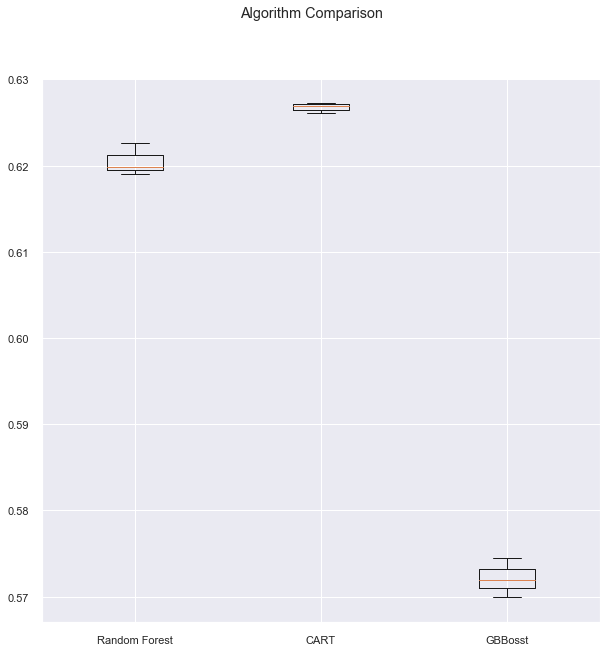

In [92]:
seed = 200
# prepare models
models = []

models.append(('Random Forest', RandomForestClassifier(n_estimators=50)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GBBosst', GradientBoostingClassifier()))


# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=seed)
    cv_results = model_selection.cross_val_score(model,X_train , y_train, cv=kfold, scoring='recall')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [93]:
param_grid = [
  {'max_depth': [10,20,30,50, 100], 'min_samples_split': [2,4,5,6,7,8]}
 ]

# Selection of the parameters from the Grid search and calculating the scores by AUC_ROC curve 
scores = ['precision', 'recall']

for score in scores:
    clf = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='accuracy')
    clf.fit(X_train , y_train)


print("Best parameters set found on development set:")
clf.best_params_

Best parameters set found on development set:


{'max_depth': 10, 'min_samples_split': 6}

In [94]:
# Deployed Machine learning model with optimal parameters 
Cart = DecisionTreeClassifier(max_depth=10, min_samples_split=7) 
Cart.fit(X_train , y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

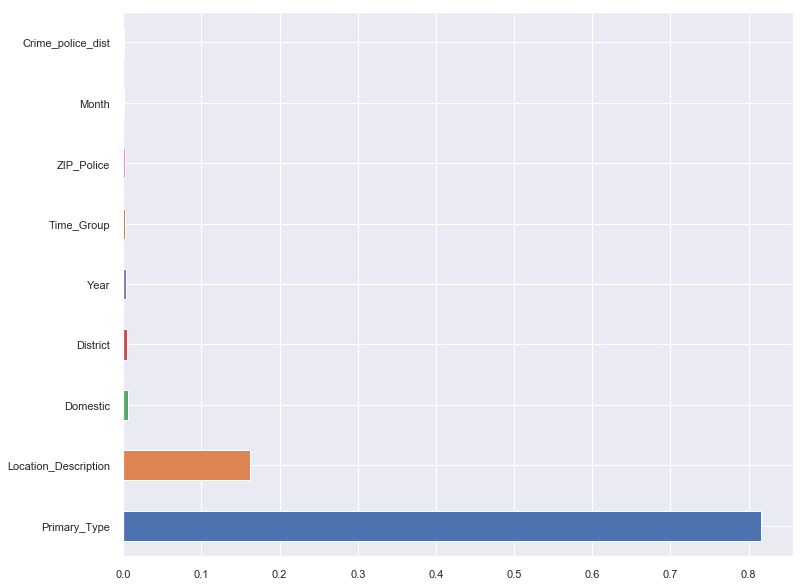

In [95]:
feat_importances = pd.Series(Cart.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [96]:

#Predict Output
predicted_0= Cart.predict(X_test)
print(classification_report(y_test, predicted_0))


              precision    recall  f1-score   support

       False       0.87      0.97      0.92    155056
        True       0.89      0.59      0.71     55250

   micro avg       0.87      0.87      0.87    210306
   macro avg       0.88      0.78      0.81    210306
weighted avg       0.87      0.87      0.86    210306



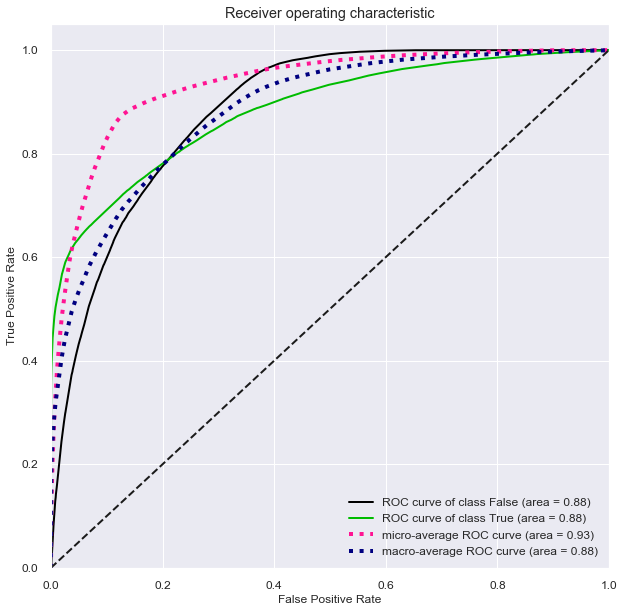

In [97]:
y_probas = Cart.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas,figsize=(10, 10) ,title='Receiver operating characteristic' ,plot_macro=True,plot_micro=True)
plt.show()

In [98]:
X_test['Primary_Type'] = Primary_Type.inverse_transform(X_test['Primary_Type'])
X_test['Location_Description'] = Location_Description.inverse_transform(X_test['Location_Description'])
X_test['Domestic'] = Domestic.inverse_transform(X_test['Domestic'])

X_test['Year']  = Year.inverse_transform(X_test['Year'] )
X_test['Time_Group'] = Time_Group.inverse_transform(X_test['Time_Group'])
X_test['Month'] = Month.inverse_transform(X_test['Month'] )

X_test['District'] = District.inverse_transform(X_test['District'])
X_test['ZIP_Police'] = ZIP_Police.inverse_transform(X_test['ZIP_Police'])
X_test['Crime_police_dist']  = Crime_police_dist.inverse_transform(X_test['Crime_police_dist'])


In [99]:
X_test['Predicted_Arrest'] = predicted_0

In [100]:
X_test.head(2)

,Primary_Type,Location_Description,Domestic,Year,Time_Group,Month,District,ZIP_Police,Crime_police_dist,Predicted_Arrest
535008,NARCOTICS,APARTMENT,False,2013,Early Afternoon,2,10,60623.0,1.0,True
879328,THEFT,RESIDENTIAL YARD (FRONT/BACK),False,2014,Early Morning,7,15,60644.0,1.0,False


In [101]:
X_test[(X_test['Primary_Type'] == 'THEFT') & (X_test['Predicted_Arrest'] == False)].head(5)

,Primary_Type,Location_Description,Domestic,Year,Time_Group,Month,District,ZIP_Police,Crime_police_dist,Predicted_Arrest
879328,THEFT,RESIDENTIAL YARD (FRONT/BACK),False,2014,Early Morning,7,15,60644.0,1.0,False
623075,THEFT,RESIDENCE-GARAGE,False,2013,Morning,6,12,60608.0,3.0,False
589300,THEFT,OTHER,False,2013,Morning,1,11,60612.0,1.0,False
856638,THEFT,"SCHOOL, PUBLIC, BUILDING",False,2014,Morning,6,2,60609.0,2.0,False
915832,THEFT,RESIDENCE,False,2014,Early Afternoon,7,10,60623.0,1.0,False
